In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb


df = pd.read_csv("dane_treningowe_model.csv")
df['date'] = pd.to_datetime(df['date'])

df['ndvi_lag1'] = df['ndvi'].shift(1)
df['ndvi_fast1'] = df['ndvi'].shift(-1)

window = 5

df_ml = df.dropna()

features = ['ndvi_lag1', 'ndvi', 'temp_short','temp_long','precip_mm','water_energy']
X = df_ml[features]
y = df_ml['ndvi_fast1']

In [ ]:
# from sklearn.ensemble import HistGradientBoostingRegressor
split = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# model = HistGradientBoostingRegressor(
#     max_iter=500,
#     learning_rate=0.05,
#     max_depth=9,
#     random_state=42,
#     early_stopping=True,        # włącz early stopping
#     n_iter_no_change=20,        # ile iteracji bez poprawy
#     validation_fraction=0.1     # część train używana jako walidacja
# )
# model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(f"Błąd średni (MAE): {mean_absolute_error(y_test, predictions):.4f}")
print(f"Wynik R2 (celność): {r2_score(y_test, predictions):.4f}")

Błąd średni (MAE): 0.0265
Wynik R2 (celność): 0.9178


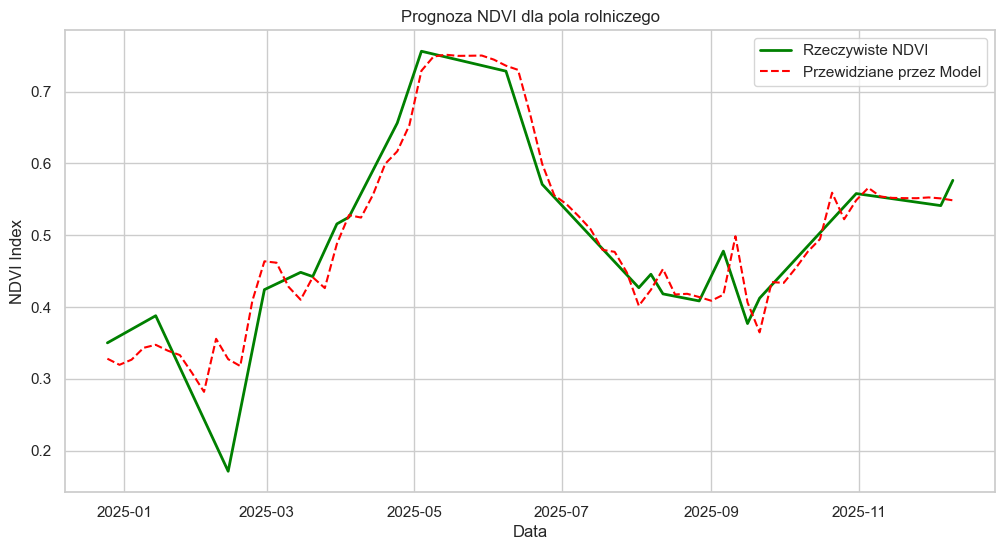

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_ml['date'].iloc[split:], y_test, label='Rzeczywiste NDVI', color='green', linewidth=2)
plt.plot(df_ml['date'].iloc[split:], predictions, label='Przewidziane przez Model', color='red', linestyle='--')
plt.title('Prognoza NDVI dla pola rolniczego')
plt.xlabel('Data')
plt.ylabel('NDVI Index')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from joblib import dump, load
dump(model,"model.joblib")


['model.joblib']

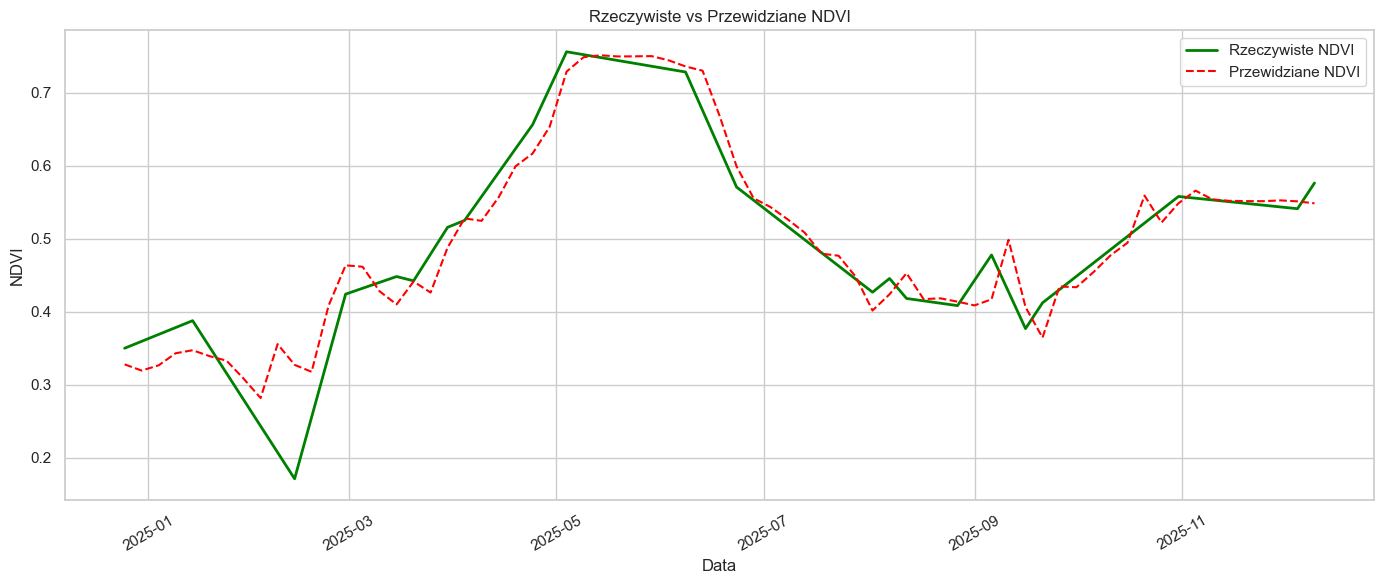

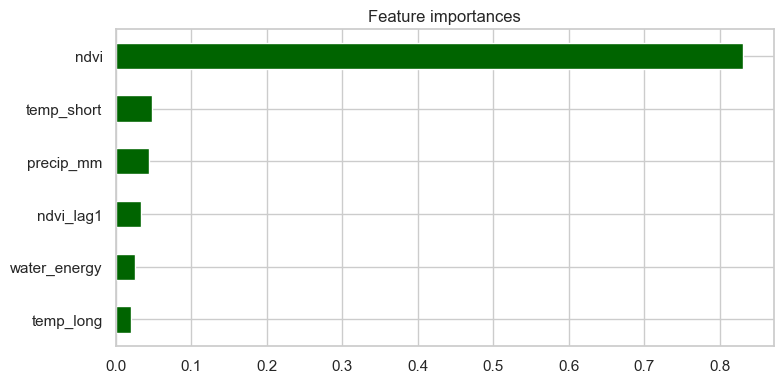

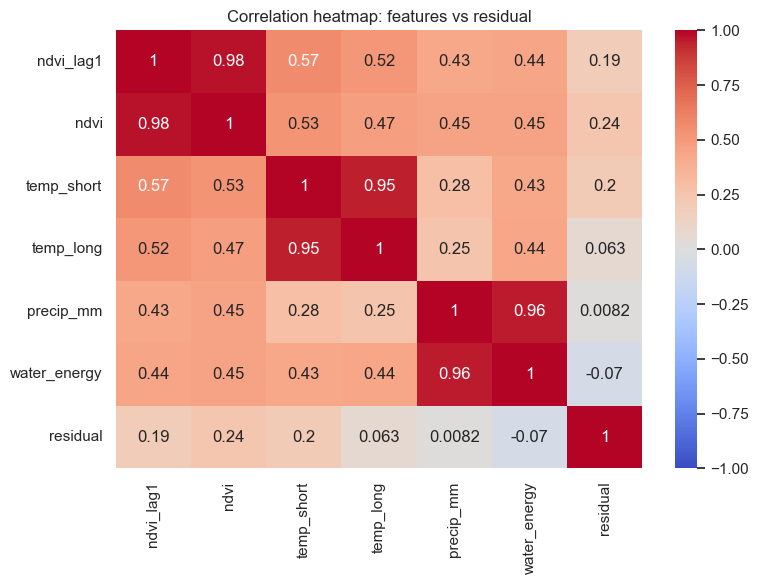

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

dates_test = df_ml.loc[X_test.index, 'date']

plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test, label='Rzeczywiste NDVI', color='green', linewidth=2)
plt.plot(dates_test, pd.Series(predictions, index=X_test.index), label='Przewidziane NDVI', color='red', linestyle='--')
plt.title('Rzeczywiste vs Przewidziane NDVI')
plt.xlabel('Data')
plt.ylabel('NDVI')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=features).sort_values()
    plt.figure(figsize=(8,4))
    feat_imp.plot(kind='barh', color='darkgreen')
    plt.title('Feature importances')
    plt.tight_layout()
    plt.show()

pred_series = pd.Series(predictions, index=X_test.index)
residuals = y_test - pred_series

df_heat = df_ml.loc[X_test.index, features].copy()
df_heat['residual'] = residuals
corr = df_heat.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation heatmap: features vs residual')
plt.tight_layout()
plt.show()

